# TOLIMAN Jitter Analysis

In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'
os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

# jax
import dLux as dl
import dLuxToliman as dlT
import jax
from jax import device_count
from jax import random as jr
from jax import numpy as np
import jax.scipy as jsp

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import zodiax as zdx
import optax

%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# Enable 64bit precision (note this must be run in the first cell of the notebook)
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)

In [2]:
def run_grad_desc(
        model,
        data,
        params,
        optimisers: dict,
        iters=100,
        jitter_model: bool = True,
        plot=False,
        ):
    """
    Run gradient descent on a model.
    """

    if jitter_model:
        @zdx.filter_jit
        @zdx.filter_value_and_grad(params)
        def loss_func(model, data):
            model_array = model.jitter_model()
            return -np.nansum(jsp.stats.poisson.logpmf(data, model_array))
    
    # use regular dot model
    else:
        @zdx.filter_jit
        @zdx.filter_value_and_grad(params)
        def loss_func(model, data):
            model_array = model.model()
            return -np.nansum(jsp.stats.poisson.logpmf(data, model_array))

    # initial run
    # model = initial_model
    loss, grads = loss_func(model, data) # Compile
    print("Initial Loss: {}".format(loss))

    # optimisers = [*map(lambda lr: optax.adam(lr, b1=0.85, b2=0.999), learning_rates.values())]

    # run gradient descent
    optim, opt_state = zdx.get_optimiser(model, params, optimisers)
    losses, models_out = [], []

    with tqdm(range(iters), desc='Gradient Descent') as t:
        for i in t: 

            loss, grads = loss_func(model, data)
            updates, opt_state = optim.update(grads, opt_state)
            model = zdx.apply_updates(model, updates)
            models_out.append(model)
            losses.append(loss)

            if np.isnan(np.array(grads.get(params))).sum() != 0:
                raise ValueError("NaN gradient")
            if np.isneginf(np.array(grads.get(params))).sum() != 0:
                raise ValueError("Neginf gradient")
            
            t.set_description("Loss: {:.6e}".format(loss)) # update the progress bar

    if plot:
        plt.figure()
        plt.title("Log Poisson Loss")
        plt.xlabel("Epoch")
        plt.plot(range(iters), losses)
        plt.show()

        plt.figure()
        for param in params:
            param_out = [m.get(param) for m in models_out]
            plt.plot(range(iters), param_out, label=param)
            plt.xlabel("Epoch")
            plt.legend()
            plt.show()


    return models_out[-1]


In [3]:
angle = 0.
mag = 0.5*0.375
shear = 0.2
r = 0.25e-4

# SETTING UP THE MODELS
oversample = 4
norm_osamp = 6
det_pscale = 0.375
det_npixels = 128 #128
kernel_size = 17
n_psfs = 4

lin_params = {"jitter_mag": mag, "jitter_angle": angle, "jitter_shape": 'linear', "n_psfs": n_psfs}
shm_params = {"jitter_mag": mag, "jitter_angle": angle, "jitter_shape": 'shm', "n_psfs": n_psfs}
norm_params = {"r": r, "shear": shear, "phi": angle, "kernel_size": kernel_size}
radial_orders = [2, 3]

# Creating common optical system
optics = dlT.TolimanOpticalSystem(
    oversample=oversample,
    psf_npixels=det_npixels,
    radial_orders=radial_orders,
    )
optics = optics.divide('aperture.basis', 1e9) # Set basis units to nanometers
norm_optics = optics.set("oversample", norm_osamp)

# Creating common source
src = dlT.AlphaCen()

# creating telescopes
lin_det = dl.LayeredDetector([('Downsample', dl.Downsample(oversample))])
shm_det = lin_det
norm_det = dl.LayeredDetector([
    ('Jitter', dlT.GaussianJitter(**norm_params)),
    ('Downsample', dl.Downsample(norm_osamp)),
])

lin_tel = dlT.JitteredToliman(source=src, optics=optics, **lin_params).set('detector', lin_det)
shm_tel = dlT.JitteredToliman(source=src, optics=optics, **shm_params).set('detector', shm_det)
norm_tel = dlT.Toliman(source=src, optics=norm_optics).set('detector', norm_det)

# creating simulated data
lin_data = lin_tel.jitter_model()
shm_data = shm_tel.jitter_model()
norm_data = norm_tel.model()

# setting norm_tel to a reasonable oversample
norm_tel = norm_tel.set(['oversample', "Downsample.kernel_size"], 2*[oversample])

In [32]:
jitter_model_fn = lambda model, data: jsp.stats.poisson.logpmf(model.jitter_model(), data).sum()
calc_cov = lambda model, data, parameters: zdx.covariance_matrix(model, parameters, jitter_model_fn, data, shape_dict={'wavelengths': 1})
norm_calc_cov = lambda model, data, parameters: zdx.covariance_matrix(model, parameters, zdx.poiss_loglike, data, shape_dict={'wavelengths': 1})

models = {
    'lin': lin_tel.set(
        ["separation", "jitter_mag", "jitter_angle"],
        [np.array(1.05 * lin_tel.separation), np.array(0.5 * lin_tel.jitter_mag), 5 + np.array(lin_tel.jitter_angle)],
        ),
    'shm': shm_tel.set(
        ["separation", "jitter_mag", "jitter_angle"],
        [np.array(1.05 * shm_tel.separation), np.array(0.5 * shm_tel.jitter_mag), 5 + np.array(shm_tel.jitter_angle)],
        ),
    "norm": norm_tel.set(
        [
            "separation",
            "Jitter.r",
            "Jitter.shear",
            "Jitter.phi",
        ],
        [
            np.array(1.05 * norm_tel.separation),
            np.array(1.05 * norm_tel.Jitter.r), 
            np.array(0.9),
            5. + np.array(norm_tel.Jitter.phi),
        ],
    ),
    }

loglike_fns = {'lin': jitter_model_fn, 'shm': jitter_model_fn, "norm": zdx.poiss_loglike}
datas = {
    'lin': lin_data,
    'shm': shm_data,
    "norm": norm_data,
    }

common_params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
    'wavelengths',
    'psf_pixel_scale',  
]

lin_params = [
    'jitter_mag',
    'jitter_angle',
    'aperture.coefficients',
]

norm_params = [
    'Jitter.r',
    'Jitter.shear',
    'Jitter.phi',
    'aperture.coefficients',
]

params = {
    "lin": common_params + lin_params,
    "shm": common_params + lin_params,
    "norm": common_params + norm_params,
}

cov_fns = {
    "lin": zdx.filter_jit(calc_cov),
    "shm": zdx.filter_jit(calc_cov),
    "norm": zdx.filter_jit(norm_calc_cov),
}

In [33]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e100}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e100, shed_dict)


base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)
base_adam = lambda vals: optax.adam(vals)

sgd = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))
adam = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

Initial Loss: 566725.7087886154


Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

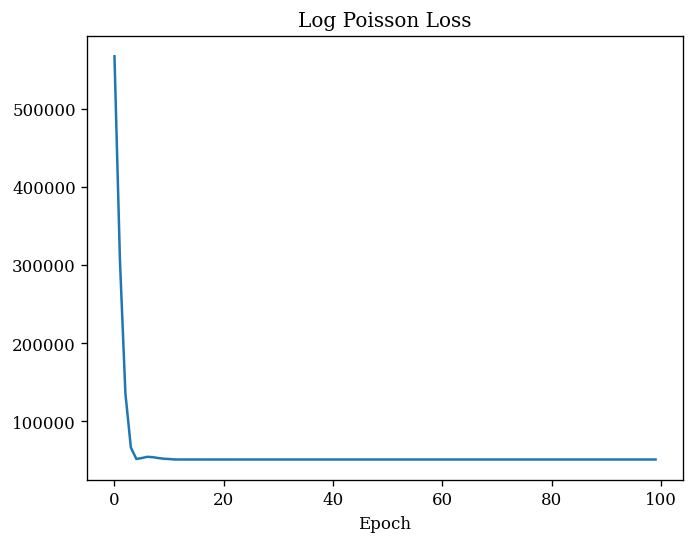

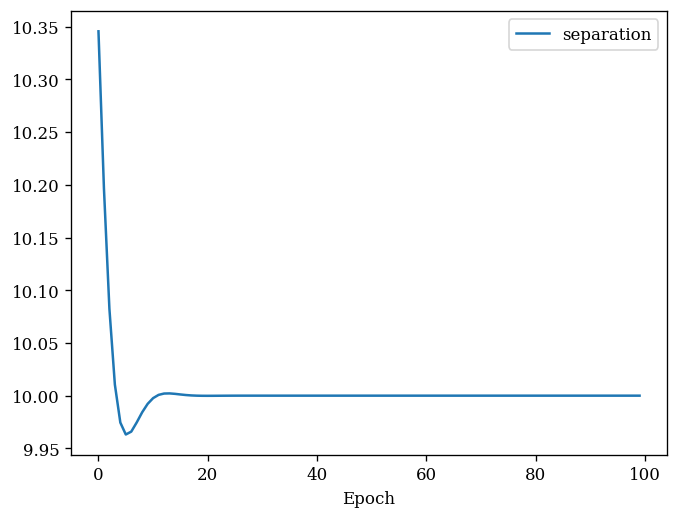

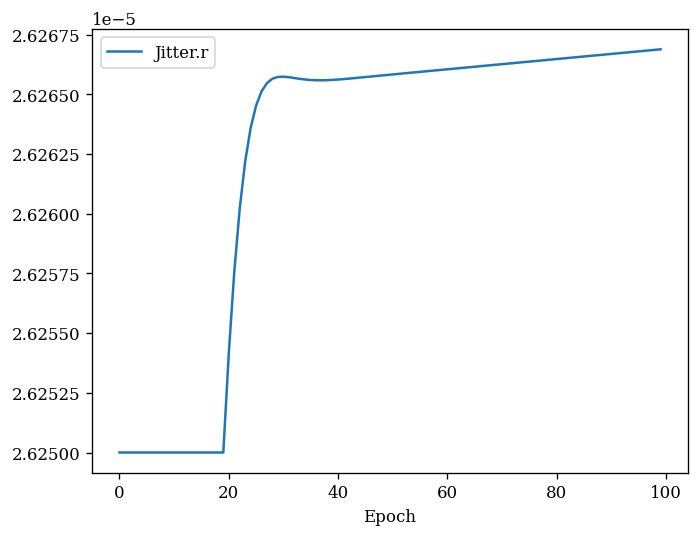

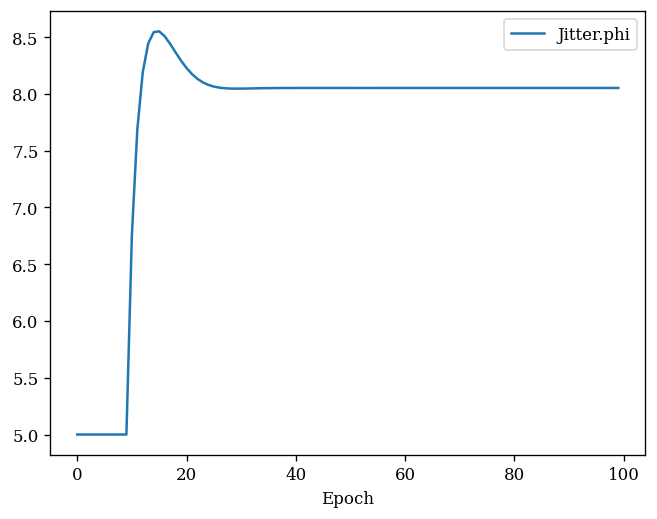

In [53]:
# plt.rcParams["figure.dpi"] = 300

optimisers = {
    "separation": sgd(5e-8, 0),
    "Jitter.r": sgd(1e-15, 20, (150, 3)),
    # "Jitter.shear": sgd(1e-10, 10, (150, 3)),
    "Jitter.phi": sgd(2e-3, 10),
}

gd_model = run_grad_desc(
    models['norm'],
    datas['lin'],
    list(optimisers.keys()),
    optimisers=list(optimisers.values()),
    iters=100,
    jitter_model=False,
    plot=True,
)


In [ ]:
seps = {}

# Gradient descent
optimisers = {
    "jitter_mag": sgd(1.5e-6, 10),
    "jitter_angle": sgd(3e-1, 10),
    "separation": sgd(5e-8, 0),
}

for model_key in models.keys():
    model = models[model_key]
    for data_key in tqdm(datas.keys()):
        data = datas[data_key]
        if model_key == "norm":
            jitter_flag = False
        else:
            jitter_flag = True

        gd_model = run_grad_desc(
            model,
            data,
            list(optimisers.keys()),
            optimisers=list(optimisers.values()),
            iters=2000,
            jitter_model=jitter_flag,
            plot=False,
        )

        cov = cov_fns[model_key](gd_model, data, params[model_key])
        sep = np.sqrt(np.abs(cov[0, 0]))
        seps[f"{model_key}_{data_key}"] = float(sep)
print(seps)

In [ ]:
maxtrix = 1e3*np.array(list(seps.values())).reshape(2, 3)
print(maxtrix)

plt.figure(figsize=(6, 3))
plt.imshow(maxtrix, cmap='Wistia', origin='upper')
plt.xticks([0, 1, 2], ['Linear', 'SHM', 'Norm'])
plt.yticks([0, 1,], ['Linear', 'SHM',])
for i in range(maxtrix.shape[0]):
    for j in range(maxtrix.shape[1]):
        plt.text(j, i, f"{maxtrix[i, j]:.5f}", ha='center', va='center', color='k')
plt.colorbar(label='Separation Error (arcsec)')
plt.xlabel('Data')
plt.ylabel('Model')

plt.show()

In [ ]:
@zdx.filter_jit
# @zdx.filter_value_and_grad(params)
def loss_func(model, data):
    return -np.nansum(jsp.stats.poisson.logpmf(data, model.model()))
    return -zdx.chi2_loglike(model, data)

In [ ]:

rs = np.logspace(-8, -3, 100)
for data_key in datas.keys():
    Ls = []
    min_index = 0
    min_L = float('inf')
    for i, r in enumerate(rs):
        L = loss_func(norm_tel.set('Jitter.r', r), datas[data_key])
        Ls.append(L)
        if L < min_L:
            min_L = L
            min_index = i

    Ls = np.array(Ls)

    plt.loglog(rs, Ls, label=data_key)
    plt.axvline(norm_tel.Jitter.r)
    plt.scatter(rs[min_index], min_L, marker='x', color='red')

plt.title(f'Log Poisson Loss')
plt.xlabel('r')
plt.legend()
plt.show()


# Biases

In [ ]:
import matplotlib as mpl
d = datas['lin']

n = jr.poisson(jr.PRNGKey(0), d)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(n, norm=mpl.colors.PowerNorm(gamma=0.5))
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(d, norm=mpl.colors.PowerNorm(gamma=0.5))
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(d-n)
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
import random
sep_dict = {}
n_realisations = 10000

# Gradient descent
optimisers = {
    "jitter_mag": sgd(1.5e-6, 10),
    "jitter_angle": sgd(3e-1, 10),
    "separation": sgd(5e-8, 0),
}

for i in tqdm(range(n_realisations), desc='Noise Realisations'):
    for model_key in tqdm(models.keys(), desc="Models"):
        model = models[model_key]
        for data_key in tqdm(datas.keys(), desc='Data Arrays'):
            data = datas[data_key]
            if model_key == "norm":
                jitter_flag = False
            else:
                jitter_flag = True

            save_path = f"data/biases/{model_key}_{data_key}.npy"

            try:
                sep_values = np.load(save_path)
            except:
                sep_values = np.array([], dtype=np.float64)

            noisy_data = jr.poisson(
                jr.PRNGKey(random.randint(0, int(1e8))), 
                data,
                )

            gd_model = run_grad_desc(
                model,
                noisy_data,
                list(optimisers.keys()),
                optimisers=list(optimisers.values()),
                iters=40,
                jitter_model=jitter_flag,
                plot=False,
            )

            np.save(save_path, np.append(sep_values, gd_model.separation))


In [ ]:
# import random
# sep_dict = {}
# n_realisations = 3000

# for model_key in tqdm(models.keys(), desc="Models"):
#     model = models[model_key]
#     for data_key in tqdm(datas.keys(), desc='Data Arrays'):
#         data = datas[data_key]
#         if model_key == "norm":
#             jitter_flag = False
#         else:
#             jitter_flag = True

#         sep_values = []

#         for i in tqdm(range(n_realisations), desc='Noise Realisations'):
#             noisy_data = jr.poisson(
#                 jr.PRNGKey(random.randint(0, int(1e8))), 
#                 data,
#                 )

#             gd_model = run_grad_desc(
#                 model,
#                 noisy_data,
#                 list(optimisers.keys()),
#                 optimisers=list(optimisers.values()),
#                 iters=40,
#                 jitter_model=jitter_flag,
#                 plot=False,
#             )

#             sep_values.append(gd_model.separation)

#         sep_dict[f"{model_key}_{data_key}"] = np.array(sep_values)

# zdx.experimental.serialise('data/sep_dict.zdx', sep_dict)


In [ ]:
# zdx.experimental.serialise('data/sep_dict.zdx', sep_dict)


In [ ]:
%matplotlib inline

import scienceplots
plt.style.use(['science', 'bright', 'no-latex'])

results = zdx.experimental.deserialise('data/sep_dict.zdx')

n_bins = 30
true_sep = 10.0
fontsize = 20

fig, ax = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=True)
fig.subplots_adjust(
    top=0.915,
    bottom=0.106,
    left=0.074,
    right=0.985,
    hspace=0.0,
    wspace=0.0,
    )

for i in range(2):
    for j in range(3):

        # mu, sigma = jax.scipy.stats.norm.fit(results[key])
        key = f"{list(models.keys())[i]}_{list(datas.keys())[j]}"
        results = np.load(f"data/biases/{key}.npy")
        offset_hist = 1e3 * (results - true_sep)  # in milliarcseconds


        ax[i][j].hist(
            offset_hist,
            bins=n_bins,
            density=True,
            color="cornflowerblue",
            )
        ax[i][j].set(
            title=f"{key}",
            xlabel=r'Recovered $-$ True Separation [mas]',
            xlim=(-1.2, 1.2),
            yticks=[],
            )
        
        ax[i][j].axvline(0, color='darkviolet', linestyle='--')

        # Generate the best-fit normal distribution curve
        mu = np.mean(offset_hist)
        std = np.std(offset_hist)

        xmin, xmax = plt.xlim()
        
        xs = np.linspace(xmin, xmax, 100)
        bell_curve = jax.scipy.stats.norm.pdf(xs, mu, std)

        one_sigma_xs = np.linspace(mu - std, mu + std, 100)
        one_sigma_bell = jax.scipy.stats.norm.pdf(one_sigma_xs, mu, std)

        # Plot the normal distribution curve
        ax[i][j].plot(xs, bell_curve, 'k', linewidth=2)
        ax[i][j].fill_between(one_sigma_xs, one_sigma_bell, color='gold', alpha=0.3, zorder=1)

        if j == 0:
            ax[i][j].set_ylabel(f"{list(models.keys())[i]}", fontsize=fontsize, rotation=0, ha='right')
        else:
            ax[i][j].set(
                ylabel=None,
            )
        if i == 0:
            ax[i][j].set(
                xlabel=None,
            )
            ax[i][j].set_title(f"{list(datas.keys())[j]}", fontsize=fontsize)  # Set the text size of the title
        else:
            ax[i][j].set(
                title=None,
            )

# plt.tight_layout()
# plt.savefig('figs/biases.png', dpi=500)
plt.show()
